In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature
import pandas as pd
import random
%matplotlib inline

In [7]:
# Read coordinates from files
sealions_df = pd.read_csv('./sealions.csv', dtype={"coord_x": int, "coord_y": int, "class": str, "filename": str})
empty_df = pd.read_csv('./empty.csv', dtype={"coord_x": int, "coord_y": int, "filename": str})
file_names_sea_lions = sealions_df.filename.unique()
file_names_background = empty_df.filename.unique()

# Create global variable for data sets
data_set_sea_lions = []
data_set_background = []

In [8]:
# Load images and extract 96x96 patches for sea lions
for file in file_names_sea_lions:
    image = cv2.imread("./kaggle_sea_lions/Train/" + file)
    df = sealions_df[sealions_df['filename'] == file]
    for row in df.iterrows():
        x = row[1]['coord_x']
        y = row[1]['coord_y']
        patch = image[y-48:y+48, x-48:x+48, :]
        data_set_sea_lions.append(list((patch, "sea lion")))

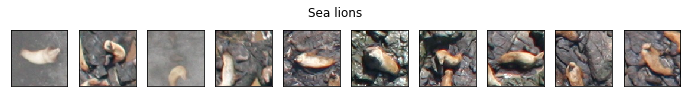

In [20]:
# Display samples
tmp_disp = random.sample(data_set_sea_lions, 10)
f, ax = plt.subplots(1, 10, figsize=(12, 1.5))
f.suptitle("Sea lions")
axes = ax.flatten()
i = 0
for a in axes:
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(tmp_disp[i][0], cv2.COLOR_BGR2RGB))
    i = i+1


In [21]:
# Load images and extract 96x96 patches for background
for file in file_names_background:
    image = cv2.imread("./kaggle_sea_lions/Train/" + file)
    df = empty_df[empty_df['filename'] == file]
    for row in df.iterrows():
        x = row[1]['coord_x']
        y = row[1]['coord_y']
        patch = image[y-48:y+48, x-48:x+48, :]
        data_set_background.append(list((patch, "backgroud")))

TypeError: Image data cannot be converted to float

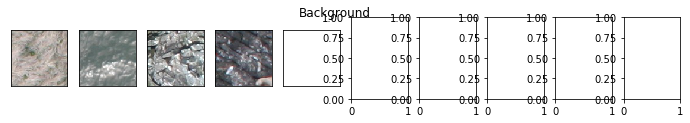

In [22]:
# Display samples
tmp_disp = random.sample(data_set_background, 10)
f, ax = plt.subplots(1, 10, figsize=(12, 1.5))
f.suptitle("Background")
axes = ax.flatten()
i = 0
for a in axes:
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(tmp_disp[i][0], cv2.COLOR_BGR2RGB))
    i = i+1